In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pretty_midi as pm
from IPython.display import Audio
%run DTW_plt.ipynb

In [19]:
def d(a, b):
    return a - b

def dtd(x, x_prime, q=2):
    """
    Calculate the distance between points
    """
    R = np.zeros((len(x), len(x_prime)))
    for i in range(len(x)):
        for j in range(len(x_prime)):
            R[i,j] = d(x[i],x_prime[j]) ** q
    return R
    

def dtw(x, x_prime, q=2):
    """
    Dynamic Time Wrapping, impl by https://rtavenar.github.io/blog/dtw.html
    
    x_prime: the sequence to be matched to
    q: Minkowski distance power
    """
    R = np.zeros((len(x), len(x_prime)))
    
    for i in range(len(x)):
        for j in range(len(x_prime)):
            R[i, j] = d(x[i], x_prime[j]) ** q
            if i > 0 or j > 0:
                R[i, j] += min(
                  R[i-1, j  ] if i > 0             else 9999999,
                  R[i  , j-1] if j > 0             else 9999999,
                  R[i-1, j-1] if (i > 0 and j > 0) else 9999999
                  # Note that these 3 terms cannot all be
                  # inf if we have (i > 0 or j > 0)
                )
    return R

def plot_dtw(res, q=1):
    """
    input two sequences, draw the dtw heatmap
    """
    plt.imshow(1/(res + 1)**q) # avoid zero division

def data(res):
    return pd.DataFrame(res)

def get_dtw_mapping(x, xprime):
    res = dtw(x, xprime)
    rows, cols = res.shape
    mapping = [(0,0)]
    i, j = 0, 0

    xm = lambda x:res[x[0],x[1]]
    while i < rows - 1 and j < cols - 1:
        neighbors = [(i + 1, j), (i, j + 1), (i + 1, j + 1)]
        if xm(neighbors[2]) == 0:
            i,j = neighbors[2]
            mapping.append((i,j))
        else:
            i, j = min(neighbors, key=lambda x: res[x[0], x[1]])
            mapping.append((i, j))
    return mapping

In [20]:
def get_matched_indices(seq_map):
    """
    Return list of indices which maps x to x_prime, given sequence mapping

    @param seq_map: output from get_dtw_mapping
    @return: indices of x and x_prime, where x mapped to x_prime (shoudl be non-overlapping)
    """
    prev_idx = -1
    x_indices = []
    xp_indices = []
    for idx, i in enumerate(seq_map):
        if idx >=1 and prev_idx == seq_map[idx][1]:
            continue # skip forward
        x_indices.append(i[0])
        xp_indices.append(i[1])
        prev_idx = seq_map[idx][1]
    assert len(x_indices) == len(xp_indices)
    return x_indices, xp_indices

In [21]:
def generate_midi(x, pitches, scale=1.0):
    """
    Generate midi seq (audio) given a sequence x
    @param x: array of 0 and 1,
    @param pitches: array of pitches to be used. len >= count(1) in x
    @param scale: speed, smaller faster
    """
    midi = pm.PrettyMIDI()
    piano = pm.Instrument(program=pm.instrument_name_to_program('Acoustic Grand Piano'))
    midi.instruments.append(piano)

    notes = []
    i_pt = 0
    for i,e in enumerate(x):
        if e == 1:
            # onset:
            notes.append((i*scale, (i+1)*scale, pitches[i_pt], 100))
            i_pt+=1

    for start, end, pitch, velocity in notes:
        note = pm.Note(velocity=velocity, pitch=pitch, start=start, end=end)
        piano.notes.append(note)

    return Audio(data=midi.synthesize(), rate=44100)

def generate_full_midi(x, scale=1.0):
    """
    Generate midi seq (audio) given a sequence x
    @param x: array of 0 and midi,
    @param scale: speed, smaller faster
    """
    midi = pm.PrettyMIDI()
    piano = pm.Instrument(program=pm.instrument_name_to_program('Acoustic Grand Piano'))
    midi.instruments.append(piano)

    notes = []
    for i,e in enumerate(x):
        if e != 0:
            # onset:
            notes.append((i*scale, (i+1)*scale, e, 100))

    for start, end, pitch, velocity in notes:
        note = pm.Note(velocity=velocity, pitch=pitch, start=start, end=end)
        piano.notes.append(note)

    return Audio(data=midi.synthesize(), rate=44100)

In [66]:
def generate_mapped_midi_seq(x, xprime, prpitches):
    """
    Input two sequences. Maps x to xprime pitches. Returns a midi sequence

    x is comparable to unpitched onset event list.
    xprime is comparable to score midi.
    
    @param x: array of onsets/silence, one element is a tick/time step
    @param xprime:  array of onsets/silence, one element is a tick/time step
    @param prpitches: array of midi numbers - pitches for each xprime onset (where xprime != 0)
    """
    if np.count_nonzero(xprime) > len(prpitches):
        print("Insufficient pitches provided!")
        return

    a = x.copy()
    aprime = xprime.copy()
    
    dtw_map = get_dtw_mapping(a, aprime)
    xid, xpid = get_matched_indices(dtw_map)

    # Override xprime with prpitches:
    ixp = 0
    for i, e in enumerate(aprime):
        if e != 0:
            aprime[i] = prpitches[ixp]
            ixp+=1

    # Maps xprime pitches to x
    for i in range(len(xid)):
        if a[xid[i]] != 0 and aprime[xpid[i]] == 0:
            print("Warning: input onset can not be mapped to a score onset!", "idx:", i,
                  'matching x[{}]:{} with xprime[{}]:{}'.format(xid[i], a[xid[i]], xpid[i], aprime[xpid[i]]))
        a[xid[i]] = aprime[xpid[i]]
    return a

# DTW is awesome

In [23]:
def dtw_basic_example():
    seq = [
        np.array([1,3,2,3,4,5,6,6,7,8,6,7,8,9,10,11,12,13]),
        np.array([1,3,4,5,6,7,8,9,10,11,12,13])
    ]
    res = dtw(seq[0],seq[1])
    plt.imshow(1/(res + 1))

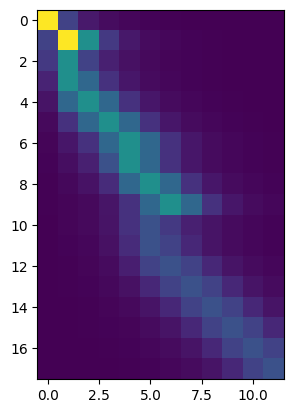

In [7]:
dtw_basic_example()

## DTW can get trapped by local minima
- although starting from 9 is a direct copy of the x_prime,
- because of big previous values, even though the distance is updated by 1
- it is ignored in min(xi-1j, xij-1, xi-1j-1)

In [8]:
seq = [
    np.array([1,2,3,4,5,6,7,9,11,1,3,4,5,6,7,8,9,6,7,9]),
    np.array([1,3,4,5,6,7,8,9,6,7,9])
]
result = dtw(seq[0],seq[1])

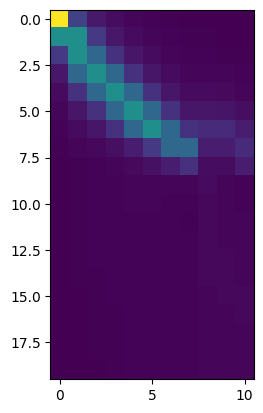

In [9]:
plt.imshow(1/(result+1))

# DTW for Onset Time Wrapping
- Now, we want to map onset events with pre-determined onset lists

## Exact Mapping (tempo varying)

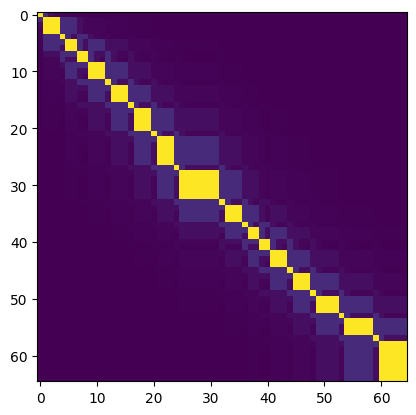

In [80]:
exact = [
    np.array([1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0, ]),
    np.array([1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0, 1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0])
]
onset_res = dtw(exact[0],exact[1])
plot_dtw(onset_res, 3)

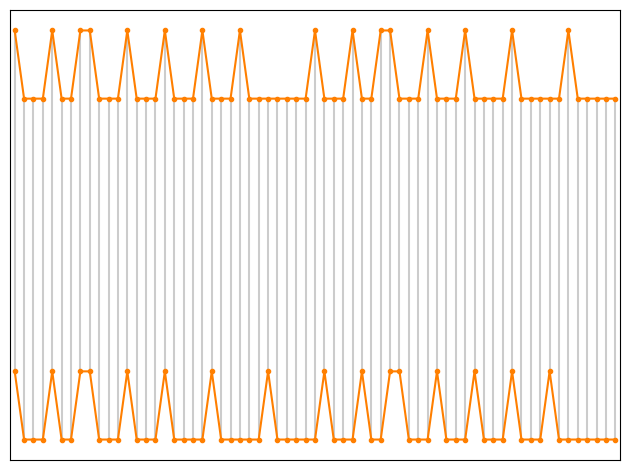

In [81]:
plt_dtw(exact[0],exact[1])

In [82]:
print("This is the score midi")
generate_midi(exact[1],[64,64,64,64,65,64,60,64,64,64,64,64,65,64,60,64], 0.2)

This is the score midi


In [83]:
print("This is the input midi")
generate_midi(exact[0],[64,64,64,64,65,64,60,64,64,64,64,64,65,64,60,64], 0.2)

This is the input midi


In [84]:
ex_mapped_midi = generate_mapped_midi_seq(exact[0], exact[1], [64,64,64,64,65,64,60,64,64,64,64,64,65,64,60,64])
print("This is the mapped midi")
generate_full_midi(ex_mapped_midi, 0.2)

This is the mapped midi


## Missing Input Onset Mapping (tempo varying)
problems:
- onset may map to 0 due to missing input

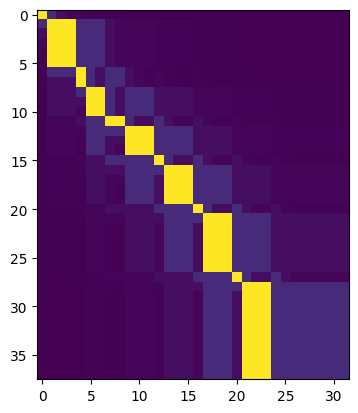

In [285]:
miss = [
    np.array([1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]),
    np.array([1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0])
]
onset_res = dtw(miss[0],miss[1])
plot_dtw(onset_res, 3)

In [286]:
print("This is the score midi")
generate_midi(miss[1],[64,64,64,64,65,64,60,64], 0.2)

This is the score midi


In [287]:
print("This is the input midi")
generate_midi(miss[0],[64,64,64,65,64,60,64], 0.2)

This is the input midi


In [288]:
miss_mapped_midi = generate_mapped_midi_seq(miss[0], miss[1], [64,64,64,64,65,64,60,64])
generate_full_midi(miss_mapped_midi, 0.2)

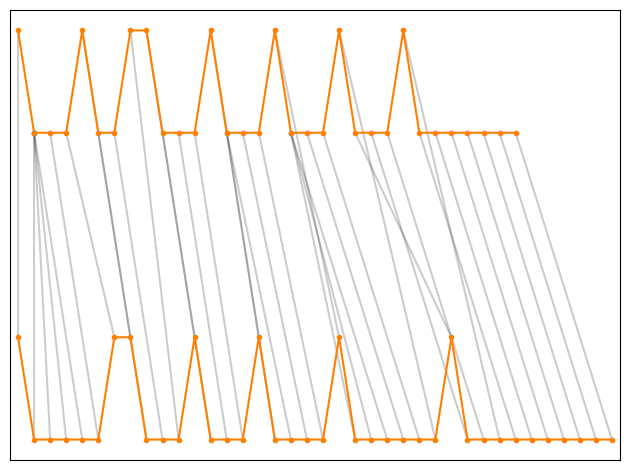

In [294]:
plt_dtw(miss[0],miss[1])

### Missing Input Onset Mapping (tempo varying) - encode beat by considering beat level


#### 1. Augment all non-zero onset beats

In [68]:
missbt = [
    np.array([4,0,0,0,0,0,1,4,0,0,0,2,0,0,0,4,0,0,0,0,2,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0]),
    np.array([1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0])
]
for i in range(len(missbt[1])):
    if missbt[1][i] == 0:
        continue
    if i % 8 == 0:
        missbt[1][i]+=2
    if i % 4 == 0:
        missbt[1][i]+=1
    # if i % 1 == 0:
    #     missbt[1][i]+=0.5

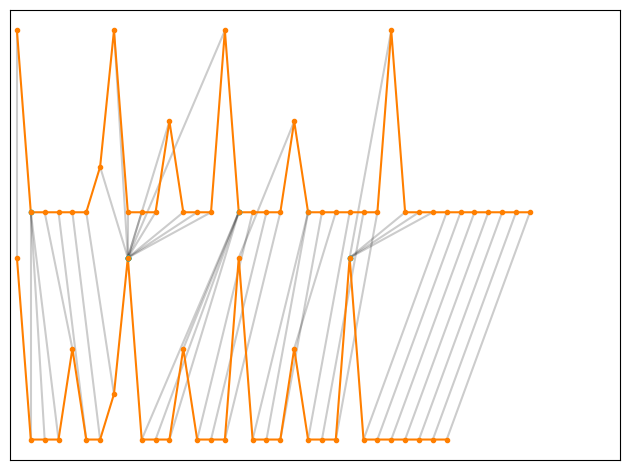

In [79]:
plt_dtw(missbt[1],missbt[0])

In [70]:
missbt_mapped_midi = generate_mapped_midi_seq(missbt[0], missbt[1], [64,64,64,64,65,64,60,64])
generate_full_midi(missbt_mapped_midi, 0.2)

In [78]:
mbt_map = get_dtw_mapping(missbt[0],missbt[1])
[print(i) for i in get_matched_indices(mbt_map)]

[0, 1, 2, 3, 6, 6, 6, 6, 7, 8, 10, 10, 11, 12, 14, 14, 15, 16, 19, 19, 20, 21, 26, 26, 27, 28]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


[None, None]

#### 2. Augment all beats

In [ ]:
missbt = [
    np.array([4,0,0,0,0,0,1,4,0,0,0,2,0,0,0,4,0,0,0,0,2,0,0,0,0,0,0,4,0,0,0,0,1,0,0,0,0,0]),
    np.array([1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0])
]
for i in range(len(missbt[1])):
    if i % 8 == 0:
        missbt[1][i]+=2
    if i % 4 == 0:
        missbt[1][i]+=1
    # if i % 1 == 0:
    #     missbt[1][i]+=0.5

In [64]:
missbt[1]

array([4, 0, 0, 0, 2, 0, 0, 1, 4, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 2, 0,
       0, 0, 4, 0, 0, 0, 1, 0, 0, 0])

# TODO:
1. fix plt_dtw bug. have it accept my dtw mat/path
2. think about tempo variation